UDG - CUCEA - MCD - Desarrollo de Proyecto I  
Proyecto final
Alumnos: Fernando Arevalo y Carmen Herrera

Instalación de librerías

In [ ]:
#pip install pandas requests beautifulsoup4 openai  seaborn newsapi-python statsmodels 

Llamado de librerías

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import nltk
import requests
import time

from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from newsapi import NewsApiClient
from datetime import datetime, timedelta
from openai import OpenAI
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Análisis exploratorio de datos (EDA)

### Primero Seleccionaremos las Acciones
Para este análisis exploratorio elegiremos 5 de las acciones más capitalizadas:

1. Apple Inc. (AAPL)
2. Microsoft Corporation (MSFT)
3. Amazon.com, Inc. (AMZN)
4. Alphabet Inc. (GOOGL)
5. Meta Platforms, Inc. (META) (anteriormente Facebook)

### Segundo descargaremos los datos,y los guardaremos correctamente estructurados

#### Paso 1: Descargar los Datos con yfinance

In [ ]:

# Lista de símbolos
symbols = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META']

# Descargar datos
data = yf.download(symbols, start='2020-01-01', end='2021-12-31')

# Verificar los datos descargados
print(data.head())


[*********************100%***********************]  5 of 5 completed

Price       Adj Close                                                \
Ticker           AAPL       AMZN      GOOGL        META        MSFT   
Date                                                                  
2020-01-02  72.796005  94.900497  68.264961  209.150269  153.630661   
2020-01-03  72.088310  93.748497  67.907845  208.043610  151.717697   
2020-01-06  72.662697  95.143997  69.717865  211.961807  152.109909   
2020-01-07  72.320976  95.343002  69.583206  212.420410  150.722977   
2020-01-08  73.484360  94.598503  70.078476  214.573944  153.123749   

Price           Close                                                ...  \
Ticker           AAPL       AMZN      GOOGL        META        MSFT  ...   
Date                                                                 ...   
2020-01-02  75.087502  94.900497  68.433998  209.779999  160.619995  ...   
2020-01-03  74.357498  93.748497  68.075996  208.669998  158.619995  ...   
2020-01-06  74.949997  95.143997  69.890503  212.60

#### Paso 2: Aplanar el Índice de las Columnas

In [2]:
data.columns = ['_'.join(col).strip() for col in data.columns.values]

#### Paso 3: Asignar nombre al índice y resetearlo

In [3]:
data.index.name = 'Date'  # Asigna el nombre 'Date' al índice
data = data.reset_index()

#### Paso 4: Reestructurar con melt

In [4]:
data_melted = pd.melt(data, id_vars=['Date'], var_name='Variable', value_name='Value')

In [5]:
# Paso 5: Filtrar las filas donde 'Variable' contiene '_'
data_filtered = data_melted[data_melted['Variable'].str.contains('_')]

In [6]:
# Paso 6: Separar 'Variable' en 'Attribute' y 'Ticker'
data_filtered[['Attribute', 'Ticker']] = data_filtered['Variable'].str.split('_', expand=True)

In [7]:
# Paso 7: Eliminar la columna 'Variable' y reordenar
data_filtered = data_filtered.drop('Variable', axis=1)
data_filtered = data_filtered[['Date', 'Ticker', 'Attribute', 'Value']]

In [8]:
# Paso 8: Verificar el resultado
print(data_filtered.head())

        Date Ticker  Attribute      Value
0 2020-01-02   AAPL  Adj Close  72.796005
1 2020-01-03   AAPL  Adj Close  72.088310
2 2020-01-06   AAPL  Adj Close  72.662697
3 2020-01-07   AAPL  Adj Close  72.320976
4 2020-01-08   AAPL  Adj Close  73.484360


In [ ]:
# Paso 9: Guardar en CSV
data_filtered.to_csv('../data/datos_acciones.csv', index=False)

### Tercer paso, Ahora que tenemos los datos correctamente estructurados y guardados, continuaremos con el Análisis Exploratorio de Datos (EDA)  
1. Descripción de los datos
2. Limpieza de datos
3. Valores faltantes (Missing values)
4. Visualización de datos
5. Referencias

### 1. Descripción de los Datos

##### Importar Librerías y Cargar los Datos  
Primero, debemos importar las librerías necesarias y cargar el archivo CSV que hemos generado.

In [ ]:

# Configurar opciones de visualización
%matplotlib inline
sns.set(style="whitegrid")

# Cargar los datos desde el archivo CSV
data = pd.read_csv('../data/datos_acciones.csv')

# Ver las primeras filas del DataFrame
print(data.head())

         Date Ticker  Attribute      Value
0  2020-01-02   AAPL  Adj Close  72.876106
1  2020-01-03   AAPL  Adj Close  72.167625
2  2020-01-06   AAPL  Adj Close  72.742661
3  2020-01-07   AAPL  Adj Close  72.400543
4  2020-01-08   AAPL  Adj Close  73.565216


##### Información General del DataFrame
Obtenemos información general sobre el DataFrame para entender su estructura.

In [2]:
# Dimensiones del DataFrame
print(f"El DataFrame tiene {data.shape[0]} filas y {data.shape[1]} columnas.")

# Información de las columnas
print(data.info())

El DataFrame tiene 15120 filas y 4 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       15120 non-null  object 
 1   Ticker     15120 non-null  object 
 2   Attribute  15120 non-null  object 
 3   Value      15120 non-null  float64
dtypes: float64(1), object(3)
memory usage: 472.6+ KB
None


##### Estadísticas Descriptivas
Calculamos estadísticas básicas para comprender mejor los datos numéricos.

In [14]:
# Convertir la columna 'Date' a tipo datetime
data['Date'] = pd.to_datetime(data['Date'])

# Estadísticas descriptivas para la columna 'Value'
print(data['Value'].describe())

count    1.512000e+04
mean     9.845173e+06
std      3.054514e+07
min      5.044350e+01
25%      1.248288e+02
50%      1.722370e+02
75%      3.002346e+02
max      4.265100e+08
Name: Value, dtype: float64


##### Variables Únicas en 'Ticker' y 'Attribute'
Identificamos las diferentes acciones y atributos presentes en el conjunto de datos.

In [15]:
# Acciones (Tickers) disponibles
tickers = data['Ticker'].unique()
print(f"Acciones disponibles: {tickers}")

# Atributos disponibles
attributes = data['Attribute'].unique()
print(f"Atributos disponibles: {attributes}")

Acciones disponibles: ['AAPL' 'AMZN' 'GOOGL' 'META' 'MSFT']
Atributos disponibles: ['Adj Close' 'Close' 'High' 'Low' 'Open' 'Volume']


### 2. Limpieza de Datos

##### Verificar Tipos de Datos
Aseguramos que las columnas tengan los tipos de datos correctos.

In [16]:
# Ver tipos de datos
print(data.dtypes)

Date         datetime64[ns]
Ticker               object
Attribute            object
Value               float64
dtype: object


##### Eliminar Duplicados
Verificamos si hay filas duplicadas y las eliminamos.

In [17]:
# Número de duplicados
num_duplicates = data.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

# Eliminar duplicados si existen
if num_duplicates > 0:
    data = data.drop_duplicates()

Número de filas duplicadas: 0


### 3. Valores Faltantes (Missing Values)

##### Detección de Valores Faltantes
Comprobamos si hay valores faltantes en el DataFrame.

In [18]:
# Conteo de valores faltantes por columna
missing_values = data.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values)

Valores faltantes por columna:
Date         0
Ticker       0
Attribute    0
Value        0
dtype: int64


##### Análisis de Valores Faltantes
- Si hubiera valores faltantes en 'Value': Esto puede afectar nuestros análisis, por lo que necesitariamos decidir cómo manejarlos.
- Opciones:
  - Eliminar las filas con valores faltantes.
  - Imputar valores faltantes: Por ejemplo, utilizando el promedio o mediana.

En nuestro caso no tuvimos valores faltantes, así que continuamos con nuestro análisis

### 4. Visualización de Datos

##### Preparación para Visualizaciones
Para facilitar las visualizaciones, pivotaremos el DataFrame para tener las columnas de atributos.

In [19]:
# Pivotar el DataFrame
data_pivot = data.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='Value').reset_index()

# Ver las primeras filas
print(data_pivot.head())

Attribute       Date Ticker   Adj Close       Close        High         Low  \
0         2020-01-02   AAPL   72.876106   75.087502   75.150002   73.797501   
1         2020-01-02   AMZN   94.900497   94.900497   94.900497   93.207497   
2         2020-01-02  GOOGL   68.264961   68.433998   68.433998   67.324501   
3         2020-01-02   META  209.150269  209.779999  209.789993  206.270004   
4         2020-01-02   MSFT  153.938202  160.619995  160.729996  158.330002   

Attribute        Open       Volume  
0           74.059998  135480400.0  
1           93.750000   80580000.0  
2           67.420502   27278000.0  
3          206.750000   12077100.0  
4          158.779999   22622100.0  


##### Visualización del Precio de Cierre Ajustado ('Adj Close') para Cada Acción

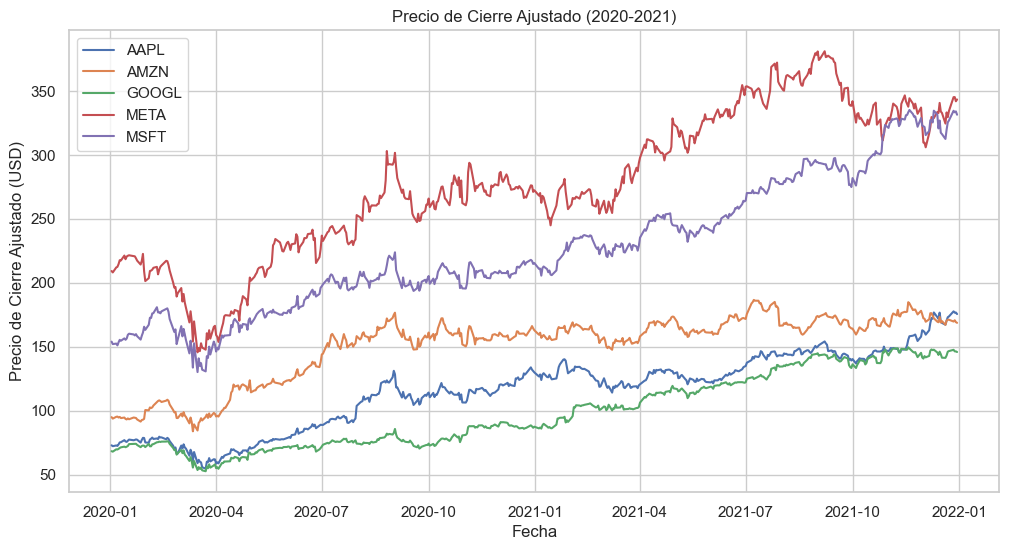

In [20]:
plt.figure(figsize=(12,6))

for ticker in tickers:
    subset = data_pivot[data_pivot['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Adj Close'], label=ticker)

plt.title('Precio de Cierre Ajustado (2020-2021)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado (USD)')
plt.legend()
plt.show()

##### Análisis de Volumen de Negociación

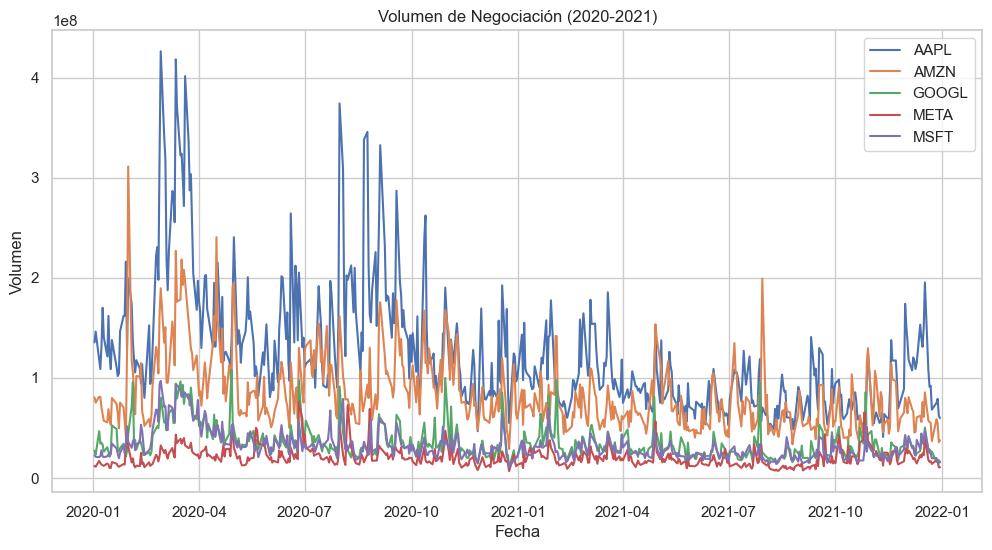

In [21]:
plt.figure(figsize=(12,6))

for ticker in tickers:
    subset = data_pivot[data_pivot['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Volume'], label=ticker)

plt.title('Volumen de Negociación (2020-2021)')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.legend()
plt.show()

##### Retornos Diarios
Calculamos y visualizamos los retornos diarios.

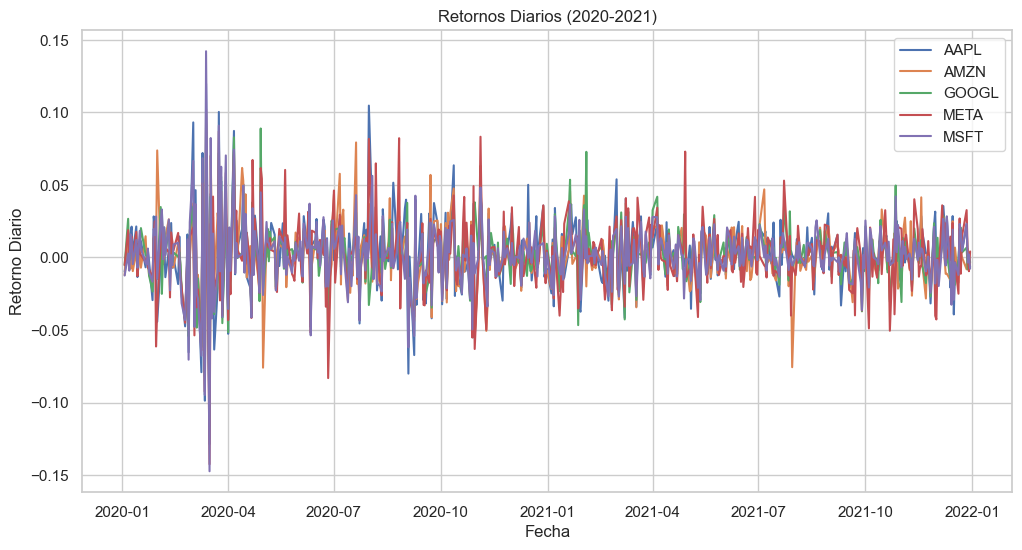

In [22]:
plt.figure(figsize=(12,6))

for ticker in tickers:
    subset = data_pivot[data_pivot['Ticker'] == ticker].sort_values('Date')
    subset['Daily Return'] = subset['Adj Close'].pct_change()
    plt.plot(subset['Date'], subset['Daily Return'], label=ticker)

plt.title('Retornos Diarios (2020-2021)')
plt.xlabel('Fecha')
plt.ylabel('Retorno Diario')
plt.legend()
plt.show()

#### Análisis de Correlación entre Acciones

##### Crear una Tabla Pivote con Precios de Cierre Ajustado

In [23]:
# Crear una tabla pivote
pivot_table = data_pivot.pivot(index='Date', columns='Ticker', values='Adj Close')

# Calcular la matriz de correlación
returns = pivot_table.pct_change()
correlation = returns.corr()

# Mostrar la matriz de correlación
print("Matriz de correlación:")
print(correlation)

Matriz de correlación:
Ticker      AAPL      AMZN     GOOGL      META      MSFT
Ticker                                                  
AAPL    1.000000  0.670216  0.698124  0.697754  0.805957
AMZN    0.670216  1.000000  0.647919  0.632579  0.695673
GOOGL   0.698124  0.647919  1.000000  0.734923  0.820704
META    0.697754  0.632579  0.734923  1.000000  0.698811
MSFT    0.805957  0.695673  0.820704  0.698811  1.000000


##### Visualizar la Matriz de Correlación

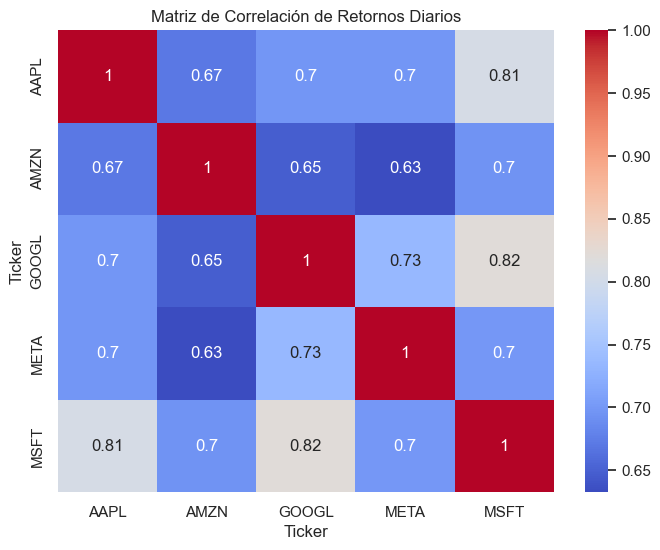

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación de Retornos Diarios')
plt.show()

##### Análisis de Correlación:
  
* Las acciones analizadas presentan altas correlaciones entre sí, lo que es común en empresas del mismo sector o en mercados alcistas generales.
* Esto sugiere que factores macroeconómicos y sentimentales podrían estar afectando a estas acciones de manera similar.

### Notas finales:  
Este EDA nos brinda una comprensión inicial de los datos históricos de las acciones más capitalizadas. Nos prepara para etapas posteriores del proyecto donde integraremos análisis más complejos para mejorar la toma de decisiones de inversión.

### Siguientes Pasos
* Análisis de Eventos Específicos:
  * Investigar fechas con movimientos significativos para entender las causas detrás de ellos.
* Incorporar Análisis de Sentimientos:
  * En futuros análisis, combinar los datos históricos con el análisis de sentimientos podría aportar mayor profundidad.
* Modelado Predictivo:
  * Utilizar los datos procesados para desarrollar modelos que puedan predecir movimientos futuros.

# Proyecto final (Continuación del proyecto)
# Análisis de Sentimientos

##### 5. Análisis de sentimientos en archivo adjunto "sentiment_analysis.py" donde proporcionamos una herramienta completa para el análisis avanzado de textos de noticias empresariales. Mediante Carga y preprocesamiento de datos, análisis de sentimientos, extracción de Entidades nombradas, Visualizaciones interactivas, Resumen de análisis, y exportación de resultados.

Web Scraper de Noticias Tecnológicas Detallado  




Extramos noticias relacionadas con acciones tecnológicas de dos fuentes específicas: Finviz y MarketWatch.  
Guardando el data set extraido en "tech_news.csv" el cual usaremos para el análisis de sentimientos realizado en el archivo adjunto "sentiment_analysis.py".

In [ ]:

class NewsScraperTech:
    def __init__(self):
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
    def get_finviz_news(self, ticker):
        """Obtiene noticias de Finviz para un ticker específico"""
        url = f'https://finviz.com/quote.ashx?t={ticker}'
        news = []
        
        try:
            response = requests.get(url, headers=self.headers)
            soup = BeautifulSoup(response.text, 'html.parser')
            news_table = soup.find('table', {'class': 'news-table'})
            
            if news_table:
                for row in news_table.findAll('tr'):
                    cols = row.findAll('td')
                    if len(cols) == 2:
                        date = cols[0].text.strip()
                        title = cols[1].text.strip()
                        link = cols[1].find('a')['href']
                        news.append({
                            'ticker': ticker,
                            'date': date,
                            'title': title,
                            'source': 'Finviz',
                            'link': link
                        })
            
        except Exception as e:
            print(f"Error obteniendo noticias de {ticker}: {str(e)}")
            
        return news

    def get_marketwatch_news(self, ticker):
        """Obtiene noticias de MarketWatch para un ticker específico"""
        url = f'https://www.marketwatch.com/investing/stock/{ticker}'
        news = []
        
        try:
            response = requests.get(url, headers=self.headers)
            soup = BeautifulSoup(response.text, 'html.parser')
            news_elements = soup.find_all('div', {'class': 'article__content'})
            
            for element in news_elements:
                title_element = element.find('a', {'class': 'link'})
                if title_element:
                    title = title_element.text.strip()
                    link = title_element['href']
                    date = element.find('span', {'class': 'article__timestamp'})
                    date = date.text if date else 'N/A'
                    
                    news.append({
                        'ticker': ticker,
                        'date': date,
                        'title': title,
                        'source': 'MarketWatch',
                        'link': link
                    })
                    
        except Exception as e:
            print(f"Error obteniendo noticias de MarketWatch para {ticker}: {str(e)}")
            
        return news

    def scrape_all_tickers(self, tickers):
        """Obtiene noticias para una lista de tickers de todas las fuentes"""
        all_news = []
        
        for ticker in tickers:
            # Obtener noticias de cada fuente
            finviz_news = self.get_finviz_news(ticker)
            marketwatch_news = self.get_marketwatch_news(ticker)
            
            # Combinar resultados
            all_news.extend(finviz_news)
            all_news.extend(marketwatch_news)
            
            # Esperar entre requests para evitar bloqueos
            time.sleep(2)
        
        # Convertir a DataFrame
        df_news = pd.DataFrame(all_news)
        
        # Limpiar y formatear fechas
        df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce')
        
        return df_news

    def save_news(self, df_news, filename='tech_news.csv'):
        """Guarda las noticias en un archivo CSV"""
        df_news.to_csv(filename, index=False)
        print(f"Noticias guardadas en {filename}")

# Ejemplo de uso
if __name__ == "__main__":
    # Lista de tickers a analizar
    tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META']
    
    # Crear instancia del scraper
    scraper = NewsScraperTech()
    
    # Obtener noticias
    news_df = scraper.scrape_all_tickers(tickers)
    
    # Guardar resultados
    scraper.save_news(news_df)
    
    # Mostrar resumen
    print("\nResumen de noticias recopiladas:")
    print(news_df.groupby(['ticker', 'source']).size())

Noticias guardadas en tech_news.csv

Resumen de noticias recopiladas:
ticker  source
AAPL    Finviz    100
AMZN    Finviz    100
GOOGL   Finviz    100
META    Finviz    100
MSFT    Finviz    100
dtype: int64


C:\Users\carmen.herrera\AppData\Local\Temp\ipykernel_32012\2566932233.py:94: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce')


### 6. Análisis de sentimientos  
Para complementar este proyecto final y prácticar más con las herramientas, realizamos este otro análisis de sentimientos.  
Para después buscar construir un modelo predictivo, es decir predecir los retornos de las acciones basandonos en el sentimiento y Rendimiento de las Acciones, para así dar un avance significativo al tema de tésis.

#### 6.1. Recolección de Datos Textuales

1.1. Configuración Inicial

1.2. Obtener Noticias Financieras  
Primero se intentó realizar webscraping de Yahoo Finance, donde si llamaba los datos pero traía 0 noticias.  
Por lo que Utilizaremos la API de NewsAPI para asegurar extraer las noticias extraer noticias

In [ ]:
# Inicializar NewsApiClient con tu clave API
newsapi = NewsApiClient(api_key='Clave_API')  # Reemplaza con tu clave API

# Lista de empresas
companies = ['Apple', 'Microsoft', 'Amazon', 'Google', 'Meta']
language = 'en'

# Fechas ajustadas al rango permitido y fechas pasadas
to_date = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')  # Ayer
from_date = (datetime.today() - timedelta(days=7)).strftime('%Y-%m-%d')  # Hace 7 días

all_articles = []

for company in companies:
    print(f"Obteniendo hasta 19 artículos para {company}")
    try:
        articles = newsapi.get_everything(
            q=company,
            from_param=from_date,
            to=to_date,
            language=language,
            sort_by='relevancy',
            page_size=19,  # Limitar a 19 artículos por empresa
            page=1  # Solo página 1
        )
        if articles['status'] == 'ok' and articles['articles']:
            # Agregar el campo 'Ticker' para identificar la empresa
            for article in articles['articles']:
                article['Ticker'] = company
            all_articles.extend(articles['articles'])
            print(f"Número de artículos obtenidos para {company}: {len(articles['articles'])}")
        else:
            print(f"No se encontraron artículos para {company}.")
    except Exception as e:
        print(f"Error al obtener artículos para {company}: {e}")

# Convertir la lista de artículos a DataFrame
news_df = pd.DataFrame(all_articles)

# Mostrar el número total de noticias obtenidas
print(f"Número total de noticias obtenidas: {len(news_df)}")

Obteniendo hasta 19 artículos para Apple
Número de artículos obtenidos para Apple: 19
Obteniendo hasta 19 artículos para Microsoft
Número de artículos obtenidos para Microsoft: 19
Obteniendo hasta 19 artículos para Amazon
Número de artículos obtenidos para Amazon: 19
Obteniendo hasta 19 artículos para Google
Número de artículos obtenidos para Google: 19
Obteniendo hasta 19 artículos para Meta
Número de artículos obtenidos para Meta: 19
Número total de noticias obtenidas: 95


In [81]:
# Ajustar las opciones de visualización
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Mostrar las primeras 10 filas
print(news_df[['Ticker', 'title', 'publishedAt']].head(10))

  Ticker                                                                                           title           publishedAt
0  Apple                                                                                       [Removed]  2024-11-26T14:11:49Z
1  Apple                                            Brazil demands Apple open up the App Store...or else  2024-11-26T14:30:16Z
2  Apple                                                                                       [Removed]  2024-11-25T15:02:23Z
3  Apple                                                                                       [Removed]  2024-11-26T15:51:24Z
4  Apple                                                                                       [Removed]  2024-11-28T13:43:13Z
5  Apple                                                                                       [Removed]  2024-11-27T16:26:41Z
6  Apple                               15 Best Apple Black Friday Deals (2024): MacBooks, iPads, AirPods  2024-

#### 6.2.  Pasos para la Limpieza y Preprocesamiento de Datos
1. Eliminar filas con títulos inválidos o vacíos.
2. Eliminar duplicados.
3. Verificar y convertir tipos de datos.
4. Gestionar valores nulos.
5. Reindexar el DataFrame.
6. Verificar los resultados de la limpieza.

1. Eliminar Filas con Títulos Inválidos o Vacíos  
Primero, eliminaremos las filas donde el título sea [Removed] o esté vacío.

In [82]:
# Eliminar filas donde 'title' es '[Removed]' o está vacío
news_df = news_df[~news_df['title'].isin(['[Removed]', '', None])]

2. Eliminar Duplicados  
Eliminamos filas duplicadas basadas en la columna 'title' para evitar analizar la misma noticia varias veces.

In [83]:
# Eliminar duplicados basados en 'title'
news_df.drop_duplicates(subset='title', inplace=True)

3. Verificar y Convertir Tipos de Datos  
Aseguramos que la columna 'publishedAt' esté en formato datetime y extraemos la fecha.

In [84]:
# Convertir 'publishedAt' a datetime y extraer la fecha
news_df['publishedAt'] = pd.to_datetime(news_df['publishedAt'], errors='coerce')
news_df['Date'] = news_df['publishedAt'].dt.date

Nota: El parámetro errors='coerce' convierte fechas inválidas en NaT (Not a Time), lo que nos permite identificarlas.

4. Gestionar Valores Nulos  
Verificamos si hay valores nulos en las columnas clave y los manejamos adecuadamente.

In [85]:
# Contar valores nulos en las columnas clave
print(news_df[['title', 'publishedAt', 'Date']].isnull().sum())

# Eliminar filas con valores nulos en 'title' o 'Date'
news_df.dropna(subset=['title', 'Date'], inplace=True)

title          0
publishedAt    0
Date           0
dtype: int64


5. Reindexar el DataFrame  
Después de eliminar filas, reindexamos el DataFrame para mantener un índice secuencial.

In [86]:
# Resetear el índice
news_df.reset_index(drop=True, inplace=True)

Visualizamos algunos resultados

In [87]:
# Mostrar las primeras filas después de la limpieza
print(news_df[['Ticker', 'title', 'Date']].head(10))

      Ticker                                                                                           title        Date
0      Apple                                            Brazil demands Apple open up the App Store...or else  2024-11-26
1      Apple                               15 Best Apple Black Friday Deals (2024): MacBooks, iPads, AirPods  2024-11-29
2      Apple  Black Friday Apple deals: The best sales we could find on AirPods, iPads, MacBooks and AirTags  2024-11-25
3      Apple                             Apple Black Friday deals: A four-pack of AirTags is on sale for $73  2024-11-29
4      Apple            Released A Month Ago, The MacBook Pro M4 Has Had Its Price Slashed Heavily By Amazon  2024-11-25
5      Apple                                               iPhone 17 ‘Slim’ rumors are still floating around  2024-11-25
6      Apple                           The best tech gifts under $100 from Apple, Samsung, Google and others  2024-11-29
7      Apple                    

#### 6.3. Análisis de Sentimientos con OpenAI

Se intentó realizar el análisis de sentimientos de cada título de noticia con con OpenAI  
Pero no tengo tokens disponibles para usar en mi cuenta. Comparto el codigo en caso de que gusten desarrollarlo.  
Lo recomendable es saltar este punto e ir directamente al punto 6.4. Analisis de sentimientos con VADER.

Instalación de la librería openai

1. Configurar la API de OpenAI

In [ ]:
print(openai.__version__)

1.55.3


Importante este código está realizado para la versión 1.55.3 de openai

In [ ]:
# Configurar tu clave API
client = OpenAI(api_key='Clave_API')  # Reemplaza con tu clave API

In [ ]:
models = client.models.list()
print("Modelos disponibles:")
for model in models.data:
    print(model.id)

Modelos disponibles:
o1-mini-2024-09-12
dall-e-2
gpt-4o-mini
gpt-4o-mini-2024-07-18
gpt-3.5-turbo
text-embedding-3-large
gpt-3.5-turbo-0125
babbage-002
davinci-002
whisper-1
dall-e-3
o1-preview
gpt-3.5-turbo-16k
o1-preview-2024-09-12
o1-mini
tts-1-hd-1106
text-embedding-ada-002
text-embedding-3-small
tts-1-hd
gpt-3.5-turbo-1106
gpt-3.5-turbo-instruct
tts-1
tts-1-1106
gpt-3.5-turbo-instruct-0914


2. Función para Obtener el Sentimiento  
Definimos una función que enviará el texto a la API de OpenAI y recibirá el sentimiento.  
En este caso usaremos el modelo "gpt-3.5-turbo", podríamos usar el modelo "gpt-4" pero tiene mayor costo, además el modelo "gpt-3.5-turbo" ya es muy potente y cumple con el objetivo de este proyecto.

In [ ]:
def get_sentiment(text):
    try:
        # No necesitamos herramientas adicionales para el análisis de sentimientos simple
        completion = client.chat.completions.create(
            model="gpt-3.5-turbo",  # Asegúrate de que este modelo está disponible para ti
            messages=[{"role": "user", "content": f"Analiza el sentimiento del siguiente texto y responde solo con 'Positivo', 'Negativo' o 'Neutral':\n\n{text}"}],
        )
        # Acceder al contenido de la respuesta
        sentiment = completion.choices[0].message.content.strip()
        # Asegurar que la respuesta es solo la clasificación
        sentiment = sentiment.split('\n')[0]
        return sentiment
    except Exception as e:
        print(f"Error al obtener el sentimiento: {e}")
        return None

3. Probar la función  
Probamos la función con un ejemplo sencillo

In [ ]:
texto_prueba = "La empresa ha tenido excelentes resultados este trimestre."
sentimiento = get_sentiment(texto_prueba)
print(f"Sentimiento del texto: {sentimiento}")

Error al obtener el sentimiento: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Sentimiento del texto: None


##### Ya desde aquí me marca que no tengo tokens disponibles en mi cuenta openai

4. Aplicar el Análisis de Sentimientos  
Aplicamos la función get_sentiment a los textos limpios. Debemos de tener en cuenta que este proceso puede tomar tiempo y tiene costos asociados con el uso de la API de OpenAI. (En nuestro caso en particular seteamos el limite de gasto de nuestra API de OpenAI a $5 USD)

In [ ]:
# Advertencia: Este proceso puede llevar tiempo y tiene costos asociados
news_df['Sentiment'] = news_df['Cleaned_Text'].apply(get_sentiment)

Error al obtener el sentimiento: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

Error al obtener el sentimiento: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

Error al

#### 6.4. Analisis de sentimientos con VADER

Dado que estamos trabajando con titulares de noticias financieras y buscamos una solución gratuita y relativamente sencilla, utilizaremos VADER con algunas adaptaciones para el dominio financiero.

Por qué VADER
* Optimizado para Textos Cortos: Ideal para titulares de noticias.
* Facilidad de Uso: Integración simple con NLTK y código fácil de implementar.
* Personalización: Puedes extender el léxico de VADER para incluir terminología financiera específica, mejorando su precisión en tu contexto.

1. Descargar el Léxico de VADER

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\skimo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

2. Importar VADER y Configurar el Analizador

In [ ]:
# Inicializar el analizador
sia = SentimentIntensityAnalyzer()

3. Extender el Léxico de VADER  
Podemos agregar términos específicos del dominio financiero al léxico de VADER:

In [92]:
# Diccionario de nuevos términos y sus puntajes
new_words = {
    'bullish': 2.0,
    'bearish': -2.0,
    'downgrade': -1.5,
    'upgrade': 1.5,
    'profit': 2.0,
    'loss': -2.0,
    # Podemos agregar mas términos según sea necesario
}

# Actualizar el léxico
sia.lexicon.update(new_words)


4. Crear la Función de Análisis de Sentimientos

In [93]:
def get_sentiment_vader(text):
    score = sia.polarity_scores(text)
    compound_score = score['compound']
    if compound_score >= 0.05:
        return 'Positivo'
    elif compound_score <= -0.05:
        return 'Negativo'
    else:
        return 'Neutral'

5. Aplicar la Función a nuestros Datos

Ejemplo con un Titular de Noticia

In [94]:
title = "The company reports record profits in the third quarter"

sentiment = get_sentiment_vader(title)
print(f"Sentiment of the title: {sentiment}")

Sentiment of the title: Positivo


Aplicamos a nuestro DataFrame

In [95]:
# Aplicar el análisis de sentimientos al título de las noticias
news_df['Sentiment'] = news_df['title'].apply(get_sentiment_vader)

In [35]:
# Mostrar las primeras 10 filas
print(news_df[['title', 'Sentiment']].head(10))

                                                                                            title Sentiment
0                                            Brazil demands Apple open up the App Store...or else   Neutral
1                               15 Best Apple Black Friday Deals (2024): MacBooks, iPads, AirPods  Positivo
2  Black Friday Apple deals: The best sales we could find on AirPods, iPads, MacBooks and AirTags  Positivo
3                             Apple Black Friday deals: A four-pack of AirTags is on sale for $73   Neutral
4            Released A Month Ago, The MacBook Pro M4 Has Had Its Price Slashed Heavily By Amazon  Negativo
5                                               iPhone 17 ‘Slim’ rumors are still floating around   Neutral
6                           The best tech gifts under $100 from Apple, Samsung, Google and others  Positivo
7                    The Apple M2 MacBook Air with 16GB of RAM is 25 percent off for Black Friday   Neutral
8             Why Spend $700

Visualizar Datos Ordenados: 

In [96]:
# Ordenar por fecha
news_df.sort_values(by='Date', inplace=True)

# Mostrar las primeras 10 filas ordenadas
print(news_df[['Date', 'Ticker', 'title', 'Sentiment']].head(10))

          Date     Ticker                                                                                                                                                                                           title Sentiment
48  2024-11-23       Meta                                                                                        Heads up! This Black Friday Meta Quest 3S deal gives you OVER $140 worth of free stuff — I'm not kidding  Positivo
8   2024-11-23      Apple                                                                                                             Why Spend $700 on an Apple Watch When You Can Get The Apple Watch SE For Just $169?   Neutral
10  2024-11-23  Microsoft                                                                                                       Amazon Has Cut Prices on The New Surface Pro to a Record Low, Our Favorite Windows Tablet  Positivo
52  2024-11-24       Meta                                                               

In [97]:
# Mostrar el número total de filas en el DataFrame
print("Número total de filas en news_df:", len(news_df))

Número total de filas en news_df: 55


In [ ]:
# Contar el número de noticias por empresa y fecha
counts = news_df.groupby(['Date', 'Ticker']).size().reset_index(name='News_Count')
print(counts.head(10))

         Date     Ticker  News_Count
0  2024-11-23      Apple           1
1  2024-11-23       Meta           1
2  2024-11-23  Microsoft           1
3  2024-11-24     Amazon           1
4  2024-11-24       Meta           2
5  2024-11-24  Microsoft           3
6  2024-11-25      Apple           3
7  2024-11-25     Google           2
8  2024-11-25       Meta           3
9  2024-11-25  Microsoft           3


#### Hasta este punto ya cumplimos con el objetivo del proyecto final al realizar web scraping, y análisis de sentimientos (análisis de texto), además en el archivo sentiment:analysis.py tambien se realiza otro web scraping, análisis de sentimientos y además graficos con Altair.

#### Por lo que lo siguiente solo será un adelanto a lo que se desarrollará a futuro para este proyecto de tésis. Lo cual se derarrollará y terminará más adelante.

### 7. Integrar los datos de sentimiento con los datos financieros de las acciones y analizar la relación entre el sentimiento del mercado y el rendimiento de las acciones.

1. Calcular el Sentimiento Promedio Diario por Empresa  
Ahora que tenemos el sentimiento de cada noticia, podemos agruparlos por fecha y empresa para obtener el sentimiento promedio diario.

In [148]:
# Mapear los sentimientos a valores numéricos
sentiment_mapping = {'Positivo': 1, 'Neutral': 0, 'Negativo': -1}
news_df['Sentiment_Score'] = news_df['Sentiment'].map(sentiment_mapping)

# Calcular el sentimiento promedio diario por empresa
daily_sentiment = news_df.groupby(['Date', 'Ticker'])['Sentiment_Score'].mean().reset_index()

# Mostrar los primeros resultados
print(daily_sentiment.head(25))

         Date     Ticker  Sentiment_Score
0  2024-11-23      Apple         0.000000
1  2024-11-23       Meta         1.000000
2  2024-11-23  Microsoft         1.000000
3  2024-11-24     Amazon         0.000000
4  2024-11-24       Meta        -0.500000
5  2024-11-24  Microsoft        -0.333333
6  2024-11-25      Apple         0.000000
7  2024-11-25     Google        -0.500000
8  2024-11-25       Meta         0.000000
9  2024-11-25  Microsoft         0.333333
10 2024-11-26     Amazon         1.000000
11 2024-11-26      Apple         0.000000
12 2024-11-26     Google         0.600000
13 2024-11-26       Meta         1.000000
14 2024-11-26  Microsoft         0.750000
15 2024-11-27     Google         1.000000
16 2024-11-27  Microsoft         0.000000
17 2024-11-28     Google         0.500000
18 2024-11-28       Meta         1.000000
19 2024-11-29     Amazon         0.000000
20 2024-11-29      Apple         0.500000
21 2024-11-29     Google        -0.333333
22 2024-11-29       Meta         1

Validación

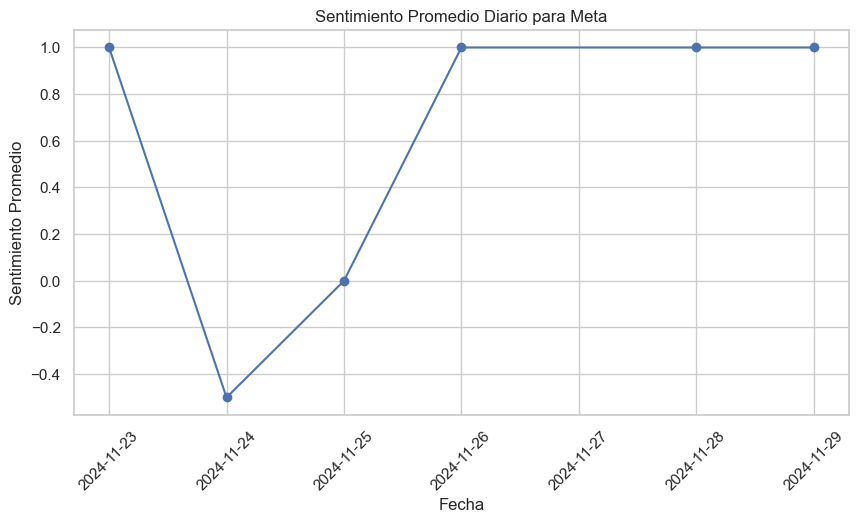

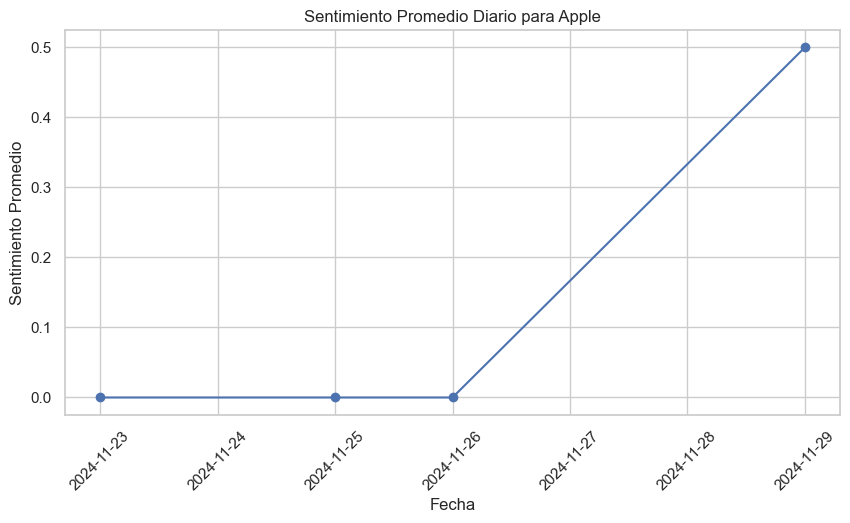

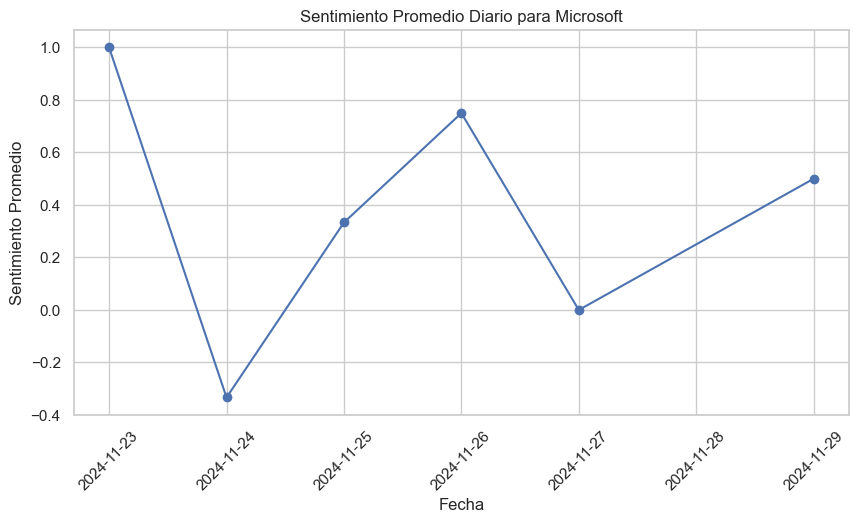

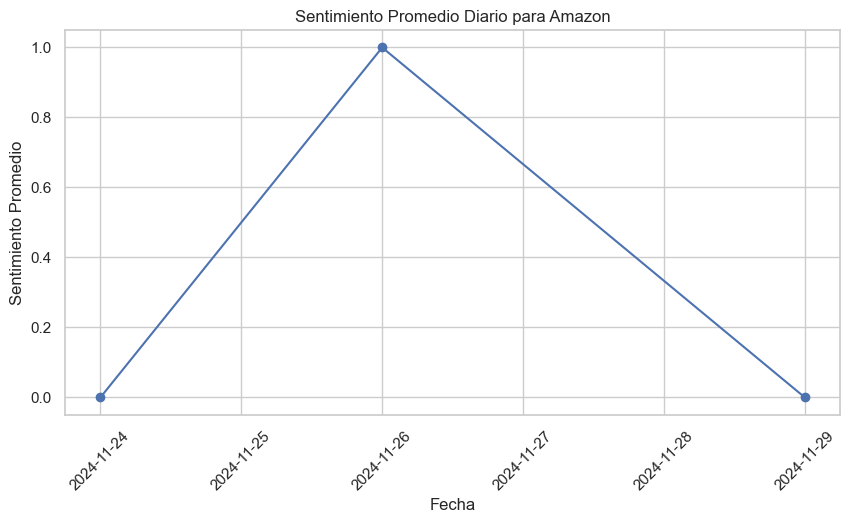

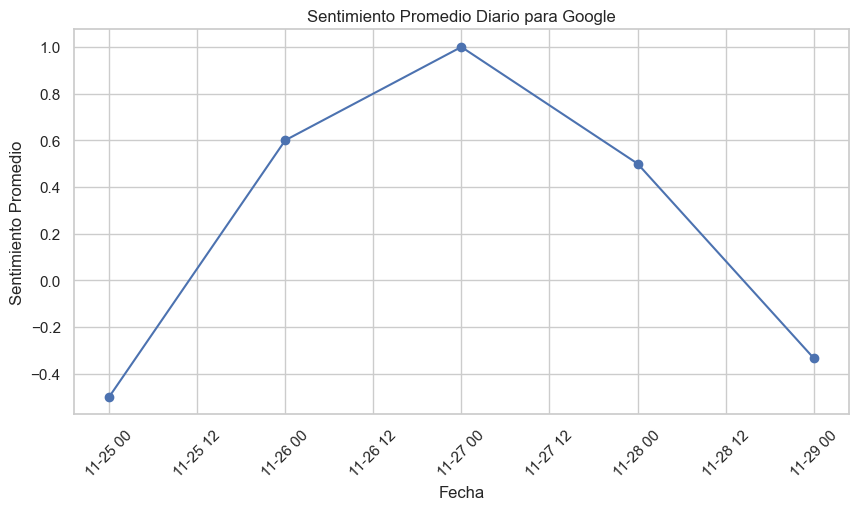

In [ ]:
for ticker in news_df['Ticker'].unique():
    company_data = daily_sentiment[daily_sentiment['Ticker'] == ticker]
    plt.figure(figsize=(10,5))
    plt.plot(company_data['Date'], company_data['Sentiment_Score'], marker='o')
    plt.title(f'Sentimiento Promedio Diario para {ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Sentimiento Promedio')
    plt.xticks(rotation=45)
    plt.show()

In [102]:
print("Valores únicos en 'Sentiment':")
print(news_df['Sentiment'].unique())

Valores únicos en 'Sentiment':
['Positivo' 'Neutral' 'Negativo']


In [103]:
# Contar valores nulos en 'Sentiment_Score'
null_count = news_df['Sentiment_Score'].isnull().sum()
print(f"Número de valores nulos en 'Sentiment_Score': {null_count}")

Número de valores nulos en 'Sentiment_Score': 0


In [104]:
# Verificar valores nulos después de la conversión
null_dates = news_df['Date'].isnull().sum()
print(f"Número de fechas nulas después de la conversión: {null_dates}")

Número de fechas nulas después de la conversión: 0


In [130]:
# Contar el número de noticias por empresa y fecha
counts = news_df.groupby(['Date', 'Ticker']).size().reset_index(name='News_Count')
print(counts.head(10))

        Date     Ticker  News_Count
0 2024-11-23      Apple           1
1 2024-11-23       Meta           1
2 2024-11-23  Microsoft           1
3 2024-11-24     Amazon           1
4 2024-11-24       Meta           2
5 2024-11-24  Microsoft           3
6 2024-11-25      Apple           3
7 2024-11-25     Google           2
8 2024-11-25       Meta           3
9 2024-11-25  Microsoft           3


In [131]:
# Diccionario para mapear los nombres de empresas a sus símbolos de cotización
ticker_symbols = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Amazon': 'AMZN',
    'Google': 'GOOGL',
    'Meta': 'META'
}

# Agregar la columna 'Ticker_Symbol' a 'daily_sentiment' mapeando desde 'Ticker'
daily_sentiment['Ticker_Symbol'] = daily_sentiment['Ticker'].map(ticker_symbols)

# Verificar si hay valores nulos en 'Ticker_Symbol'
null_ticker_symbols = daily_sentiment['Ticker_Symbol'].isnull().sum()
print(f"Número de valores nulos en 'Ticker_Symbol': {null_ticker_symbols}")

Número de valores nulos en 'Ticker_Symbol': 0


In [132]:
if null_ticker_symbols > 0:
    print("Filas con 'Ticker_Symbol' nulo:")
    print(daily_sentiment[daily_sentiment['Ticker_Symbol'].isnull()])

2. Obtener Datos Históricos de Precios de Acciones  
Necesitamos los datos de precios de las acciones de las empresas que estamos analizando para el mismo período de tiempo.

In [ ]:
# Lista de empresas y sus símbolos de cotización
ticker_symbols = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Amazon': 'AMZN',
    'Google': 'GOOGL',
    'Meta': 'META'
}

# Asegurar que 'Date' es de tipo datetime en 'daily_sentiment'
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

# Convertir los nombres de empresas a símbolos en 'daily_sentiment'
daily_sentiment['Ticker_Symbol'] = daily_sentiment['Ticker'].map(ticker_symbols)

# Fechas de inicio y fin para los datos históricos
start_date = daily_sentiment['Date'].min()
end_date = daily_sentiment['Date'].max()

# Ajustar 'end_date' para incluir el último día
end_date += timedelta(days=1)

# Convertir las fechas a cadenas de texto
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Descargar datos históricos de precios
data = yf.download(
    tickers=list(ticker_symbols.values()),
    start=start_date_str,
    end=end_date_str,
    interval='1d'
)

# Procesar los datos descargados
stock_data = data['Adj Close'].reset_index()

# Asegurar que 'Date' es de tipo datetime en 'stock_data'
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Convertir los datos de formato ancho a largo
stock_data = stock_data.melt(id_vars='Date', var_name='Ticker_Symbol', value_name='Adj Close')

# Mostrar los primeros resultados
print(stock_data.head(20))

[*********************100%***********************]  5 of 5 completed

         Date Ticker_Symbol   Adj Close
0  2024-11-25          AAPL  232.869995
1  2024-11-26          AAPL  235.059998
2  2024-11-27          AAPL  234.929993
3  2024-11-29          AAPL  237.330002
4  2024-11-25          AMZN  201.449997
5  2024-11-26          AMZN  207.860001
6  2024-11-27          AMZN  205.740005
7  2024-11-29          AMZN  207.889999
8  2024-11-25         GOOGL  167.649994
9  2024-11-26         GOOGL  169.119995
10 2024-11-27         GOOGL  169.229996
11 2024-11-29         GOOGL  168.949997
12 2024-11-25          META  565.109985
13 2024-11-26          META  573.539978
14 2024-11-27          META  569.200012
15 2024-11-29          META  574.320007
16 2024-11-25          MSFT  418.790009
17 2024-11-26          MSFT  427.989990
18 2024-11-27          MSFT  422.989990
19 2024-11-29          MSFT  423.459991


3. Agregaremos una nueva columna donde de cada Ticker_Symbol veamos si el Adj Close fue positivo =1, negativo = -1, o neutro = 0 con respecto al día anterior.

In [191]:
print(stock_data.columns)

Index(['Date', 'Ticker_Symbol', 'Adj Close'], dtype='object')


In [ ]:
# Dataframe
data = {
    'Date': [
        '2024-11-25', '2024-11-26', '2024-11-27', '2024-11-29',
        '2024-11-25', '2024-11-26', '2024-11-27', '2024-11-29',
        '2024-11-25', '2024-11-26', '2024-11-27', '2024-11-29',
        '2024-11-25', '2024-11-26', '2024-11-27', '2024-11-29',
        '2024-11-25', '2024-11-26', '2024-11-27', '2024-11-29'
    ],
    'Ticker_Symbol': [
        'AAPL', 'AAPL', 'AAPL', 'AAPL',
        'AMZN', 'AMZN', 'AMZN', 'AMZN',
        'GOOGL', 'GOOGL', 'GOOGL', 'GOOGL',
        'META', 'META', 'META', 'META',
        'MSFT', 'MSFT', 'MSFT', 'MSFT'
    ],
    'Adj Close': [
        232.869995, 235.059998, 234.929993, 237.330002,
        201.449997, 207.860001, 205.740005, 207.889999,
        167.649994, 169.119995, 169.229996, 168.949997,
        565.109985, 573.539978, 569.200012, 574.320007,
        418.790009, 427.989990, 422.989990, 423.459991
    ]
}

stock_data = pd.DataFrame(data)

# Paso 1: Asegurar que 'Date' es de tipo datetime y ordenar los datos
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data.sort_values(by=['Ticker_Symbol', 'Date']).reset_index(drop=True)

# Paso 2: Calcular la diferencia diaria en 'Adj Close'
stock_data['Adj_Close_Diff'] = stock_data.groupby('Ticker_Symbol')['Adj Close'].diff()

# Paso 3: Crear la columna 'Price Change'
stock_data['Price Change'] = stock_data['Adj_Close_Diff'].apply(
    lambda x: 1 if x > 0 else (-1 if x < 0 else 0)
)

# Alternativa utilizando NumPy:
# stock_data['Price Change'] = stock_data['Adj_Close_Diff'].apply(np.sign).fillna(0).astype(int)

# Paso 4: Eliminar la columna 'Adj_Close_Diff'
stock_data = stock_data.drop(columns=['Adj_Close_Diff'])

# Mostrar el DataFrame resultante
print(stock_data)

         Date Ticker_Symbol   Adj Close  Price Change
0  2024-11-25          AAPL  232.869995             0
1  2024-11-26          AAPL  235.059998             1
2  2024-11-27          AAPL  234.929993            -1
3  2024-11-29          AAPL  237.330002             1
4  2024-11-25          AMZN  201.449997             0
5  2024-11-26          AMZN  207.860001             1
6  2024-11-27          AMZN  205.740005            -1
7  2024-11-29          AMZN  207.889999             1
8  2024-11-25         GOOGL  167.649994             0
9  2024-11-26         GOOGL  169.119995             1
10 2024-11-27         GOOGL  169.229996             1
11 2024-11-29         GOOGL  168.949997            -1
12 2024-11-25          META  565.109985             0
13 2024-11-26          META  573.539978             1
14 2024-11-27          META  569.200012            -1
15 2024-11-29          META  574.320007             1
16 2024-11-25          MSFT  418.790009             0
17 2024-11-26          MSFT 

#### A partir de este punto aún se planea realizar el análisis de correlación, visualizaciones, construir un modelo preductivo, entre otros avances para este tema de tésis. Pero como se mencionó este solo era un adelando al avance de este proyecto. La aplicación de los dos puntos requeridos en este proyecto final ya se cumplió.

### 8. Referencias

* Librerías Utilizadas:

  * Pandas: https://pandas.pydata.org/
  * NumPy: https://numpy.org/
  * Matplotlib: https://matplotlib.org/
  * Seaborn: https://seaborn.pydata.org/
  * yfinance: https://pypi.org/project/yfinance/
  * newsapi https://newsapi.org/
  * vaderSentiment https://pypi.org/project/vaderSentiment/
* Fuentes de Datos:
  * Yahoo Finance a través de la librería yfinance.
* Documentación y Recursos Adicionales:
  * Análisis Exploratorio de Datos: https://www.kaggle.com/learn/data-cleaning
  * Visualización de Datos con Matplotlib y Seaborn: https://realpython.com/python-matplotlib-guide/
  * Análisis exploratorio de datos (EDA): https://github.com/vcuspinera/UDG_MCD_Project_Dev_I/blob/main/actividades/13_EDA.ipynb
  * News API. (n.d.). News API – Search news and blog articles on the web. https://newsapi.org/